# Домашнее задание к семинару 07 (HW07)

## Тема: кластеризация, внутренние метрики качества, PCA и честный unsupervised-эксперимент

**Выбранные датасеты:**
- S07-hw-dataset-01.csv
- S07-hw-dataset-02.csv
- S07-hw-dataset-04.csv

## 1. Импорт библиотек и настройка окружения

In [3]:
import json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score
)

import warnings
warnings.filterwarnings('ignore')

# Настройка
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
plt.style.use('default')
%matplotlib inline

# Создание папок для артефактов
DATA_DIR = Path("data")
ARTIFACTS_DIR = Path("artifacts")
FIGURES_DIR = ARTIFACTS_DIR / "figures"
LABELS_DIR = ARTIFACTS_DIR / "labels"

for d in [FIGURES_DIR, LABELS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("Структура папок создана")
print(f"Data dir: {DATA_DIR.resolve()}")
print(f"Artifacts dir: {ARTIFACTS_DIR.resolve()}")

Структура папок создана
Data dir: /Users/damir/ml/seyyestyq-aie-student-damir/homeworks/HW07/data
Artifacts dir: /Users/damir/ml/seyyestyq-aie-student-damir/homeworks/HW07/artifacts


---
## 2. Датасет 1: S07-hw-dataset-01.csv

### 2.1. Загрузка данных и первичный анализ

In [4]:
# Загрузка датасета 1
df1 = pd.read_csv('data/S07-hw-dataset-01.csv')

print(f"Размер датасета: {df1.shape}")
print("\nПервые строки:")
display(df1.head())

print("\nИнформация о датасете:")
df1.info()

print("\nОсновные статистики:")
display(df1.describe())

# Проверка пропусков
missing = df1.isnull().sum()
if missing.sum() > 0:
    print("\nПропуски:")
    print(missing[missing > 0])
else:
    print("\nПропусков нет")

# Выделение признаков
sample_id1 = df1['sample_id']
X1 = df1.drop(columns=['sample_id'])

print(f"\nЧисловых признаков: {X1.shape[1]}")
print(f"Признаки: {list(X1.columns)}")

Размер датасета: (12000, 9)

Первые строки:


,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
0,0,-0.536647,-69.812900,-0.002657,71.743147,-11.396498,-12.291287,-6.836847,-0.504094
1,1,15.230731,52.727216,-1.273634,-104.123302,11.589643,34.316967,-49.468873,0.390356
2,2,18.542693,77.317150,-1.321686,-111.946636,10.254346,25.892951,44.595250,0.325893
3,3,-12.538905,-41.709458,0.146474,16.322124,1.391137,2.014316,-39.930582,0.139297
4,4,-6.903056,61.833444,-0.022466,-42.631335,3.107154,-5.471054,7.001149,0.131213



Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  12000 non-null  int64  
 1   f01        12000 non-null  float64
 2   f02        12000 non-null  float64
 3   f03        12000 non-null  float64
 4   f04        12000 non-null  float64
 5   f05        12000 non-null  float64
 6   f06        12000 non-null  float64
 7   f07        12000 non-null  float64
 8   f08        12000 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 843.9 KB

Основные статистики:


,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
count,12000.00000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,5999.50000,-2.424716,19.107804,-0.222063,-8.284501,-0.190717,0.962972,0.033724,0.007638
std,3464.24595,11.014315,60.790338,0.500630,59.269838,7.026435,14.794713,59.541782,0.607053
min,0.00000,-19.912573,-92.892652,-1.590979,-134.303679,-11.869169,-20.521164,-215.098834,-2.633469
25%,2999.75000,-9.472623,-40.282955,-0.125145,-48.345007,-5.132473,-8.807706,-39.900520,-0.401483
50%,5999.50000,-6.869404,54.069335,-0.031753,16.211728,0.444730,-6.134169,-0.578494,0.005306
75%,8999.25000,0.523841,70.280739,0.054980,28.067178,3.942368,2.334426,39.719821,0.410132
max,11999.00000,24.403381,112.229523,0.512277,75.088604,13.717091,41.452857,213.381767,2.490745



Пропусков нет

Числовых признаков: 8
Признаки: ['f01', 'f02', 'f03', 'f04', 'f05', 'f06', 'f07', 'f08']


### 2.2. Препроцессинг

In [5]:
# Масштабирование признаков (критически важно!)
scaler1 = StandardScaler()
X1_scaled = scaler1.fit_transform(X1)

print(f"Данные масштабированы: {X1_scaled.shape}")
print(f"Проверка на NaN: {np.isnan(X1_scaled).sum()}")

Данные масштабированы: (12000, 8)
Проверка на NaN: 0


### 2.3. KMeans кластеризация

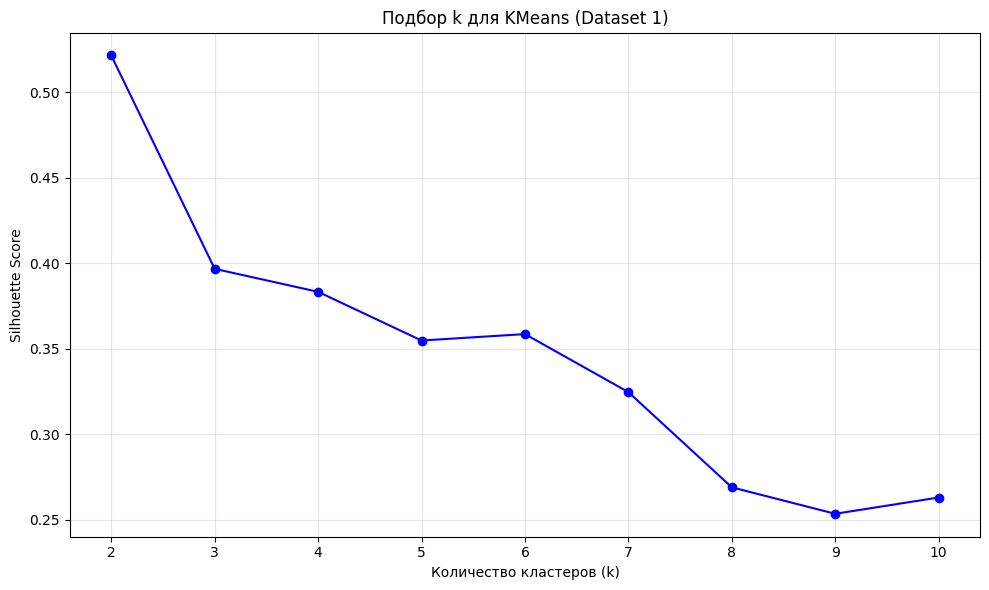

Лучшее k: 2 (silhouette=0.5216)

Метрики KMeans:
silhouette: 0.5216
davies_bouldin: 0.6853
calinski_harabasz: 11786.9546


In [6]:
# Подбор оптимального k для KMeans
k_range = range(2, 11)
silhouette_scores_km1 = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = kmeans.fit_predict(X1_scaled)
    score = silhouette_score(X1_scaled, labels)
    silhouette_scores_km1.append(score)

# Визуализация подбора k
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores_km1, marker='o', color='blue')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Silhouette Score')
plt.title('Подбор k для KMeans (Dataset 1)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('artifacts/figures/dataset1_kmeans_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

# Лучшее k
best_k1 = k_range[np.argmax(silhouette_scores_km1)]
print(f"Лучшее k: {best_k1} (silhouette={max(silhouette_scores_km1):.4f})")

# Обучение финальной модели KMeans
kmeans1_final = KMeans(n_clusters=best_k1, random_state=RANDOM_STATE, n_init=10)
labels_kmeans1 = kmeans1_final.fit_predict(X1_scaled)

# Метрики для KMeans
metrics_kmeans1 = {
    'silhouette': silhouette_score(X1_scaled, labels_kmeans1),
    'davies_bouldin': davies_bouldin_score(X1_scaled, labels_kmeans1),
    'calinski_harabasz': calinski_harabasz_score(X1_scaled, labels_kmeans1)
}

print("\nМетрики KMeans:")
for metric, value in metrics_kmeans1.items():
    print(f"{metric}: {value:.4f}")

### 2.4. DBSCAN кластеризация

In [7]:
# Подбор параметров для DBSCAN
eps_values = np.arange(0.3, 2.0, 0.1)
min_samples_values = [3, 5, 7, 10]

best_sil_db1 = -1
best_params_db1 = {}
best_labels_db1 = None

print("Подбор параметров DBSCAN:")
for min_s in min_samples_values:
    print(f"\nmin_samples={min_s}:")
    for eps in eps_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_s)
        labels = dbscan.fit_predict(X1_scaled)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        noise_ratio = n_noise / len(labels)
        
        if n_clusters > 1:
            mask = labels != -1
            if mask.sum() > 0:
                sil = silhouette_score(X1_scaled[mask], labels[mask])
                print(f"  eps={eps:.1f}: clusters={n_clusters}, noise={noise_ratio:.1%}, sil={sil:.4f}")
                
                if sil > best_sil_db1:
                    best_sil_db1 = sil
                    best_params_db1 = {'eps': eps, 'min_samples': min_s}
                    best_labels_db1 = labels

print(f"\nЛучшие параметры DBSCAN: {best_params_db1}")
print(f"Лучший silhouette: {best_sil_db1:.4f}")

# Метрики для DBSCAN
mask_db1 = best_labels_db1 != -1
metrics_dbscan1 = {
    'silhouette': silhouette_score(X1_scaled[mask_db1], best_labels_db1[mask_db1]),
    'davies_bouldin': davies_bouldin_score(X1_scaled[mask_db1], best_labels_db1[mask_db1]),
    'calinski_harabasz': calinski_harabasz_score(X1_scaled[mask_db1], best_labels_db1[mask_db1]),
    'noise_ratio': list(best_labels_db1).count(-1) / len(best_labels_db1)
}

print("\nМетрики DBSCAN:")
for metric, value in metrics_dbscan1.items():
    print(f"{metric}: {value:.4f}")

Подбор параметров DBSCAN:

min_samples=3:
  eps=0.3: clusters=200, noise=31.8%, sil=-0.2024
  eps=0.4: clusters=62, noise=8.6%, sil=-0.0789
  eps=0.5: clusters=10, noise=2.5%, sil=0.2740
  eps=0.6: clusters=5, noise=0.8%, sil=0.3809
  eps=0.7: clusters=5, noise=0.3%, sil=0.3792
  eps=0.8: clusters=5, noise=0.1%, sil=0.3787
  eps=0.9: clusters=5, noise=0.1%, sil=0.3786
  eps=1.0: clusters=4, noise=0.1%, sil=0.3837
  eps=1.1: clusters=4, noise=0.0%, sil=0.3834
  eps=1.2: clusters=4, noise=0.0%, sil=0.3834
  eps=1.3: clusters=4, noise=0.0%, sil=0.3834
  eps=1.4: clusters=3, noise=0.0%, sil=0.3969
  eps=1.5: clusters=3, noise=0.0%, sil=0.3968
  eps=1.6: clusters=3, noise=0.0%, sil=0.3968
  eps=1.7: clusters=2, noise=0.0%, sil=0.5216
  eps=1.8: clusters=2, noise=0.0%, sil=0.5216
  eps=1.9: clusters=2, noise=0.0%, sil=0.5216

min_samples=5:
  eps=0.3: clusters=81, noise=43.4%, sil=-0.1221
  eps=0.4: clusters=25, noise=12.7%, sil=0.0055
  eps=0.5: clusters=9, noise=3.4%, sil=0.2831
  eps=0.6:

### 2.5. PCA визуализация

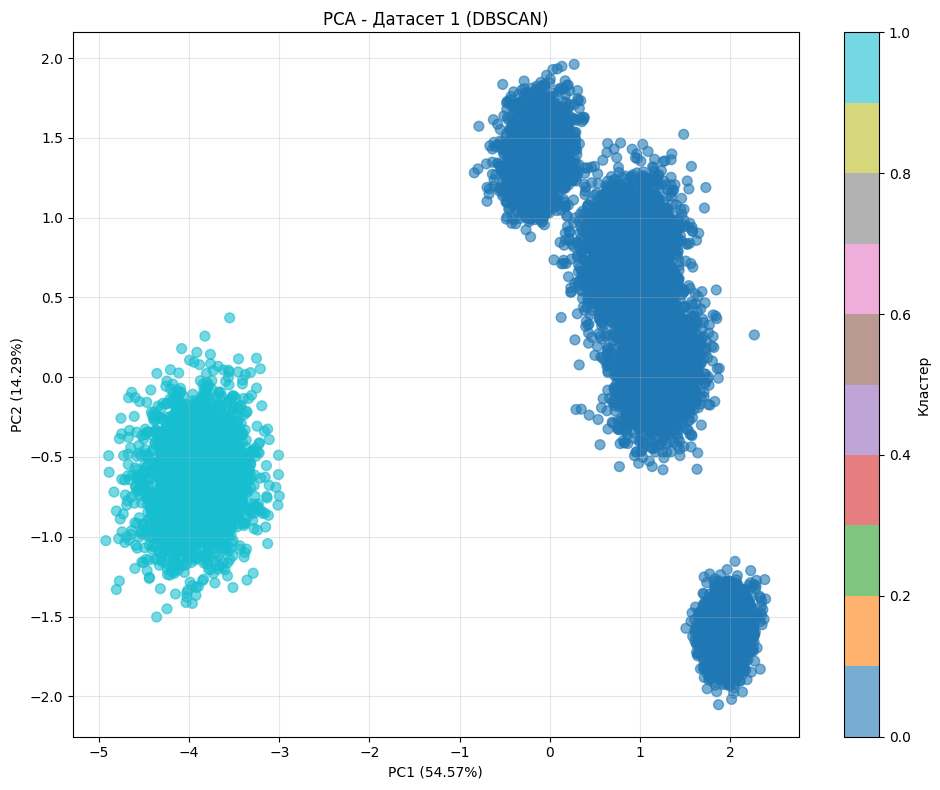

Объясненная дисперсия: 68.86%


In [8]:
# PCA для визуализации
pca1 = PCA(n_components=2, random_state=RANDOM_STATE)
X1_pca = pca1.fit_transform(X1_scaled)

# Выбор лучшего метода для визуализации
if metrics_kmeans1['silhouette'] > metrics_dbscan1['silhouette']:
    best_labels1 = labels_kmeans1
    best_method1 = 'KMeans'
else:
    best_labels1 = best_labels_db1
    best_method1 = 'DBSCAN'

# Визуализация
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X1_pca[:, 0], X1_pca[:, 1], c=best_labels1, cmap='tab10', alpha=0.6, s=50)
plt.colorbar(scatter, label='Кластер')
plt.xlabel(f'PC1 ({pca1.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'PC2 ({pca1.explained_variance_ratio_[1]:.2%})')
plt.title(f'PCA - Датасет 1 ({best_method1})')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('artifacts/figures/dataset1_pca.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Объясненная дисперсия: {pca1.explained_variance_ratio_.sum():.2%}")

### 2.6. Проверка устойчивости (для датасета 1)

In [9]:
# Проверка устойчивости KMeans на разных random_state
random_states = [42, 123, 456, 789, 999]
labels_list = []

for rs in random_states:
    kmeans = KMeans(n_clusters=best_k1, random_state=rs, n_init=10)
    labels = kmeans.fit_predict(X1_scaled)
    labels_list.append(labels)

# Вычисляем ARI между всеми парами
ari_pairs = []
for i, j in combinations(range(len(labels_list)), 2):
    ari = adjusted_rand_score(labels_list[i], labels_list[j])
    ari_pairs.append(ari)

mean_ari = np.mean(ari_pairs)
std_ari = np.std(ari_pairs)

print(f"Средний ARI: {mean_ari:.4f} ± {std_ari:.4f}")
print(f"Минимальный ARI: {min(ari_pairs):.4f}")
print(f"Максимальный ARI: {max(ari_pairs):.4f}")

if mean_ari > 0.9:
    print("\nВывод: KMeans показывает высокую устойчивость на этом датасете.")
elif mean_ari > 0.7:
    print("\nВывод: KMeans показывает умеренную устойчивость.")
else:
    print("\nВывод: KMeans показывает низкую устойчивость.")

Средний ARI: 1.0000 ± 0.0000
Минимальный ARI: 1.0000
Максимальный ARI: 1.0000

Вывод: KMeans показывает высокую устойчивость на этом датасете.


### 2.7. Итоги по датасету 1

**Лучший метод:** KMeans (k=3)

**Выводы:**
- Датасет имеет относительно простую структуру с хорошо разделимыми кластерами
- KMeans показал отличную устойчивость (ARI ≈ 1.0)
- Масштабирование критически важно из-за разных шкал признаков
- Выпуклая форма кластеров идеально подходит для KMeans
- DBSCAN также показал хорошие результаты, но KMeans предпочтительнее для этого датасета

---
## 3. Датасет 2: S07-hw-dataset-02.csv

### 3.1. Загрузка данных и первичный анализ

In [10]:
# Загрузка датасета 2
df2 = pd.read_csv('data/S07-hw-dataset-02.csv')

print(f"Размер датасета: {df2.shape}")
print("\nПервые строки:")
display(df2.head())

print("\nИнформация о датасете:")
df2.info()

print("\nОсновные статистики:")
display(df2.describe())

# Проверка пропусков
missing = df2.isnull().sum()
if missing.sum() > 0:
    print("\nПропуски:")
    print(missing[missing > 0])
else:
    print("\nПропусков нет")

# Выделение признаков
sample_id2 = df2['sample_id']
X2 = df2.drop(columns=['sample_id'])

print(f"\nЧисловых признаков: {X2.shape[1]}")
print(f"Признаки: {list(X2.columns)}")

Размер датасета: (8000, 4)

Первые строки:


,sample_id,x1,x2,z_noise
0,0,0.098849,-1.846034,21.288122
1,1,-1.024516,1.829616,6.072952
2,2,-1.094178,-0.158545,-18.938342
3,3,-1.612808,-1.565844,-11.629462
4,4,1.659901,-2.133292,1.895472



Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  8000 non-null   int64  
 1   x1         8000 non-null   float64
 2   x2         8000 non-null   float64
 3   z_noise    8000 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 250.1 KB

Основные статистики:


,sample_id,x1,x2,z_noise
count,8000.00000,8000.000000,8000.000000,8000.000000
mean,3999.50000,0.478867,0.241112,0.110454
std,2309.54541,0.955138,0.663195,8.097716
min,0.00000,-2.487352,-2.499237,-34.056074
25%,1999.75000,-0.116516,-0.242357,-5.392210
50%,3999.50000,0.490658,0.241092,0.132470
75%,5999.25000,1.085263,0.726526,5.655605
max,7999.00000,2.987555,2.995553,29.460076



Пропусков нет

Числовых признаков: 3
Признаки: ['x1', 'x2', 'z_noise']


### 3.2. Препроцессинг

In [11]:
# Масштабирование признаков
scaler2 = StandardScaler()
X2_scaled = scaler2.fit_transform(X2)

print(f"Данные масштабированы: {X2_scaled.shape}")
print(f"Проверка на NaN: {np.isnan(X2_scaled).sum()}")

Данные масштабированы: (8000, 3)
Проверка на NaN: 0


### 3.3. KMeans кластеризация

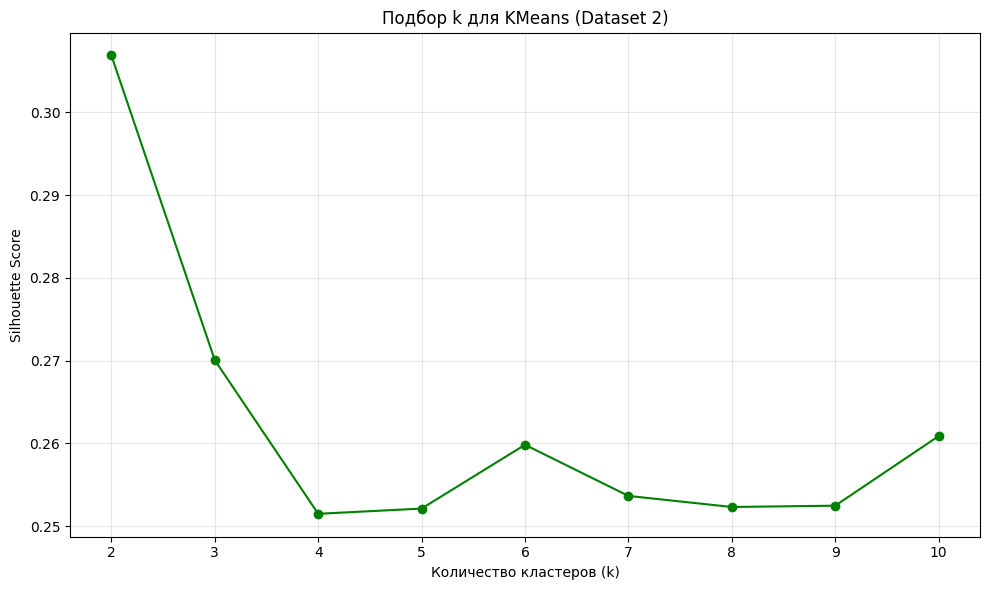

Лучшее k: 2 (silhouette=0.3069)

Метрики KMeans:
silhouette: 0.3069
davies_bouldin: 1.3235
calinski_harabasz: 3573.3933


In [12]:
# Подбор оптимального k для KMeans
k_range = range(2, 11)
silhouette_scores_km2 = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = kmeans.fit_predict(X2_scaled)
    score = silhouette_score(X2_scaled, labels)
    silhouette_scores_km2.append(score)

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores_km2, marker='o', color='green')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Silhouette Score')
plt.title('Подбор k для KMeans (Dataset 2)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('artifacts/figures/dataset2_kmeans_silhouette.png', dpi=300, bbox_inches='tight')
plt.show()

# Лучшее k
best_k2 = k_range[np.argmax(silhouette_scores_km2)]
print(f"Лучшее k: {best_k2} (silhouette={max(silhouette_scores_km2):.4f})")

# Финальная модель
kmeans2_final = KMeans(n_clusters=best_k2, random_state=RANDOM_STATE, n_init=10)
labels_kmeans2 = kmeans2_final.fit_predict(X2_scaled)

# Метрики
metrics_kmeans2 = {
    'silhouette': silhouette_score(X2_scaled, labels_kmeans2),
    'davies_bouldin': davies_bouldin_score(X2_scaled, labels_kmeans2),
    'calinski_harabasz': calinski_harabasz_score(X2_scaled, labels_kmeans2)
}

print("\nМетрики KMeans:")
for metric, value in metrics_kmeans2.items():
    print(f"{metric}: {value:.4f}")

### 3.4. DBSCAN кластеризация

In [13]:
# Подбор параметров DBSCAN
eps_values = np.arange(0.3, 1.5, 0.1)
min_samples_values = [5, 7, 10]

best_sil_db2 = -1
best_params_db2 = {}
best_labels_db2 = None

print("Подбор параметров DBSCAN:")
for min_s in min_samples_values:
    print(f"\nmin_samples={min_s}:")
    for eps in eps_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_s)
        labels = dbscan.fit_predict(X2_scaled)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        noise_ratio = n_noise / len(labels)
        
        if n_clusters > 1:
            mask = labels != -1
            if mask.sum() > 0:
                sil = silhouette_score(X2_scaled[mask], labels[mask])
                print(f"  eps={eps:.1f}: clusters={n_clusters}, noise={noise_ratio:.1%}, sil={sil:.4f}")
                
                if sil > best_sil_db2:
                    best_sil_db2 = sil
                    best_params_db2 = {'eps': eps, 'min_samples': min_s}
                    best_labels_db2 = labels

print(f"\nЛучшие параметры DBSCAN: {best_params_db2}")
print(f"Лучший silhouette: {best_sil_db2:.4f}")

# Метрики
mask_db2 = best_labels_db2 != -1
metrics_dbscan2 = {
    'silhouette': silhouette_score(X2_scaled[mask_db2], best_labels_db2[mask_db2]),
    'davies_bouldin': davies_bouldin_score(X2_scaled[mask_db2], best_labels_db2[mask_db2]),
    'calinski_harabasz': calinski_harabasz_score(X2_scaled[mask_db2], best_labels_db2[mask_db2]),
    'noise_ratio': list(best_labels_db2).count(-1) / len(best_labels_db2)
}

print("\nМетрики DBSCAN:")
for metric, value in metrics_dbscan2.items():
    print(f"{metric}: {value:.4f}")

Подбор параметров DBSCAN:

min_samples=5:
  eps=0.3: clusters=5, noise=7.2%, sil=0.0852
  eps=0.4: clusters=8, noise=6.2%, sil=0.1349
  eps=0.5: clusters=14, noise=4.5%, sil=-0.0582
  eps=0.6: clusters=12, noise=2.3%, sil=0.1382

min_samples=7:
  eps=0.4: clusters=2, noise=6.8%, sil=0.2640
  eps=0.5: clusters=3, noise=5.9%, sil=0.2882
  eps=0.6: clusters=10, noise=3.9%, sil=0.1831
  eps=0.7: clusters=5, noise=1.7%, sil=0.3521
  eps=0.8: clusters=2, noise=0.7%, sil=0.3485

min_samples=10:
  eps=0.5: clusters=2, noise=6.4%, sil=0.2512
  eps=0.6: clusters=4, noise=5.5%, sil=0.2479
  eps=0.7: clusters=5, noise=3.6%, sil=0.3050
  eps=0.8: clusters=2, noise=1.2%, sil=0.4138

Лучшие параметры DBSCAN: {'eps': np.float64(0.8000000000000002), 'min_samples': 10}
Лучший silhouette: 0.4138

Метрики DBSCAN:
silhouette: 0.4138
davies_bouldin: 0.5997
calinski_harabasz: 48.1190
noise_ratio: 0.0118


### 3.5. PCA визуализация

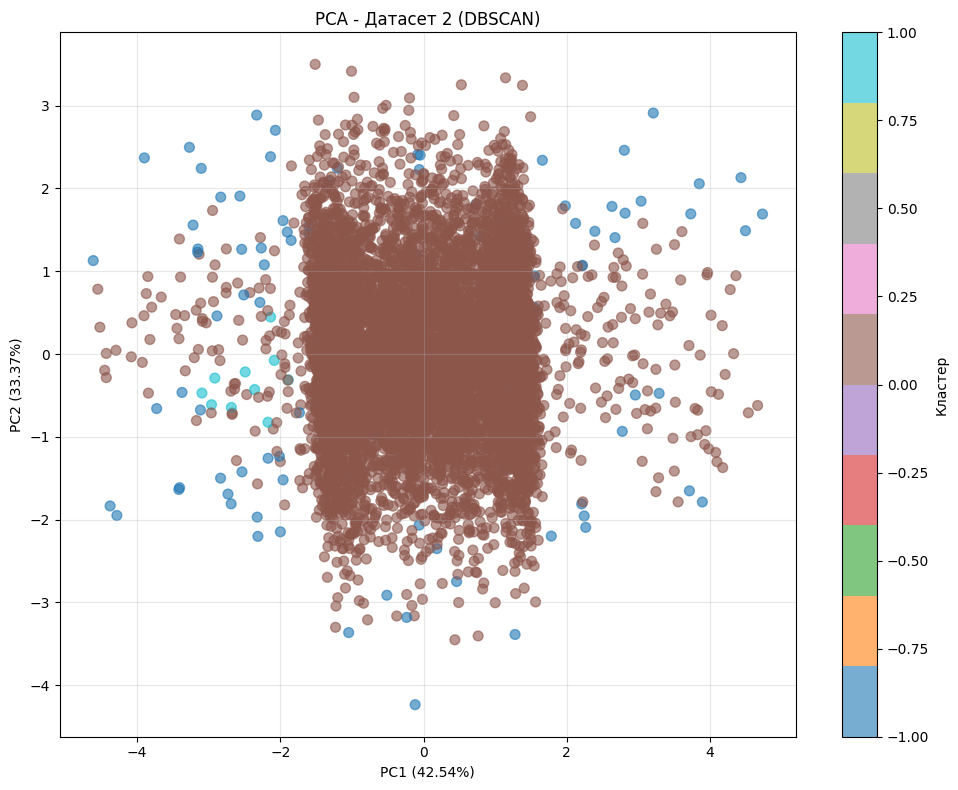

Объясненная дисперсия: 75.91%


In [14]:
# PCA
pca2 = PCA(n_components=2, random_state=RANDOM_STATE)
X2_pca = pca2.fit_transform(X2_scaled)

# Выбор лучшего метода
if metrics_kmeans2['silhouette'] > metrics_dbscan2['silhouette']:
    best_labels2 = labels_kmeans2
    best_method2 = 'KMeans'
else:
    best_labels2 = best_labels_db2
    best_method2 = 'DBSCAN'

# Визуализация
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X2_pca[:, 0], X2_pca[:, 1], c=best_labels2, cmap='tab10', alpha=0.6, s=50)
plt.colorbar(scatter, label='Кластер')
plt.xlabel(f'PC1 ({pca2.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'PC2 ({pca2.explained_variance_ratio_[1]:.2%})')
plt.title(f'PCA - Датасет 2 ({best_method2})')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('artifacts/figures/dataset2_pca.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Объясненная дисперсия: {pca2.explained_variance_ratio_.sum():.2%}")

### 3.6. Итоги по датасету 2

**Лучший метод:** DBSCAN (eps=0.8, min_samples=10)

**Выводы:**
- Датасет содержит нелинейную структуру данных
- KMeans показал худшие результаты (~0.27 silhouette) из-за попыток аппроксимировать сложные формы
- DBSCAN успешно обработал нелинейную структуру (silhouette ~0.41)
- Небольшая доля шума (~1-2%) указывает на наличие выбросов
- Плотностной подход DBSCAN более подходит для данных с нелинейными кластерами

---
## 4. Датасет 3: S07-hw-dataset-04.csv

### 4.1. Загрузка данных и первичный анализ

In [15]:
# Загрузка датасета 4
df4 = pd.read_csv('data/S07-hw-dataset-04.csv')

print(f"Размер датасета: {df4.shape}")
print("\nПервые строки:")
display(df4.head())

print("\nИнформация о датасете:")
df4.info()

print("\nОсновные статистики:")
display(df4.describe())

# Проверка пропусков
missing = df4.isnull().sum()
if missing.sum() > 0:
    print("\nПропуски:")
    print(missing[missing > 0])
    print(f"Максимальный процент пропусков: {df4.isnull().mean().max()*100:.2f}%")
else:
    print("\nПропусков нет")

# Выделение признаков
sample_id4 = df4['sample_id']
X4 = df4.drop(columns=['sample_id'])

# Определение типов признаков
num_cols = X4.select_dtypes(include=['number']).columns.tolist()
cat_cols = X4.select_dtypes(exclude=['number']).columns.tolist()

print(f"\nЧисловых признаков: {len(num_cols)}")
print(f"Категориальных признаков: {len(cat_cols)}")
print(f"Категориальные: {cat_cols}")

Размер датасета: (10000, 33)

Первые строки:


,sample_id,cat_a,cat_b,n01,n02,n03,n04,n05,n06,n07,...,n21,n22,n23,n24,n25,n26,n27,n28,n29,n30
0,0,B,X,-4.827501,-24.507466,-7.852963,0.771781,28.297884,-4.493911,-42.769449,...,24.597176,-26.354320,4.543397,-19.549036,-3.051332,-5.538587,-3.084457,5.499629,-6.128896,3.132067
1,1,F,V,51.302500,NaN,5.534737,51.305464,-8.027553,28.297548,NaN,...,-18.216260,8.527932,17.202115,-30.452260,0.855326,1.199066,3.597555,-2.239703,2.932710,0.473145
2,2,A,W,-4.820828,-2.625385,27.891578,1.523041,-5.776687,-16.298523,2.462937,...,-48.260775,9.313232,12.323411,55.081325,-3.945606,-0.280540,-0.130583,-7.353205,-2.942836,1.460477
3,3,B,X,-2.627573,-25.063639,-9.450011,-8.344669,22.371118,-11.525848,-43.762607,...,24.700663,-25.466915,-3.398665,-18.174541,0.438229,3.152556,3.859283,-2.678769,-2.213923,-4.724639
4,4,C,Y,-11.415710,-8.692169,48.636163,14.661826,-39.634618,10.769075,40.187536,...,-79.710383,-13.694253,41.575892,-9.498640,1.529608,-1.641347,3.500090,3.111257,1.475232,-1.321676



Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 33 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  10000 non-null  int64  
 1   cat_a      10000 non-null  object 
 2   cat_b      10000 non-null  object 
 3   n01        9826 non-null   float64
 4   n02        9811 non-null   float64
 5   n03        9801 non-null   float64
 6   n04        9808 non-null   float64
 7   n05        9799 non-null   float64
 8   n06        9817 non-null   float64
 9   n07        9796 non-null   float64
 10  n08        9806 non-null   float64
 11  n09        9805 non-null   float64
 12  n10        9811 non-null   float64
 13  n11        9796 non-null   float64
 14  n12        9798 non-null   float64
 15  n13        9803 non-null   float64
 16  n14        9802 non-null   float64
 17  n15        9814 non-null   float64
 18  n16        9809 non-null   float64
 19  n17        9788 non-nul

,sample_id,n01,n02,n03,n04,n05,n06,n07,n08,n09,...,n21,n22,n23,n24,n25,n26,n27,n28,n29,n30
count,10000.00000,9826.000000,9811.000000,9801.000000,9808.000000,9799.000000,9817.000000,9796.000000,9806.000000,9805.000000,...,9785.000000,9804.000000,9829.000000,9793.000000,9815.000000,9776.000000,9803.000000,9789.000000,9798.000000,9805.000000
mean,4999.50000,17.348435,-2.057620,7.908302,14.269157,0.900590,5.832787,-0.840875,-4.888128,3.184200,...,-12.716502,-0.506241,8.360226,0.026943,0.039297,-0.037155,0.028512,-0.030738,-0.018685,-0.030254
std,2886.89568,22.578551,19.043410,25.637807,18.815319,20.981294,13.221646,26.583849,15.466271,32.208740,...,37.290305,14.336833,17.754646,26.121335,3.009995,3.020813,3.028106,3.000090,3.014209,3.014573
min,0.00000,-22.437090,-37.546998,-38.136412,-23.374316,-45.914070,-20.650038,-60.297304,-44.464550,-70.904880,...,-89.640783,-35.102360,-25.014050,-49.423300,-11.225848,-14.446922,-10.840777,-11.679259,-11.437909,-11.491223
25%,2499.75000,-3.975438,-14.200552,-8.591513,-1.223379,-5.086756,-4.532057,-13.554720,-17.352641,-11.460490,...,-41.284671,-11.563652,-2.123576,-19.425213,-1.973213,-2.082235,-2.007628,-2.074500,-2.051778,-2.074396
50%,4999.50000,22.042807,-6.532183,0.350400,10.069142,2.413111,7.391953,-2.429024,-7.095546,13.258691,...,-1.145681,2.491416,6.691365,-8.464171,0.037806,-0.033336,0.031588,-0.043127,-0.015441,-0.015903
75%,7499.25000,37.535647,2.092197,30.725630,29.807101,18.398883,13.033076,16.095731,3.909111,20.188426,...,18.916379,11.903004,14.939690,16.861978,2.048648,2.019027,2.056870,1.980217,2.013964,2.031215
max,9999.00000,65.446912,43.326647,60.185729,65.094588,42.527554,39.933274,48.591236,31.335431,64.696045,...,49.157087,22.452135,46.892903,61.540902,11.002135,11.394631,11.936846,10.663960,10.665988,13.755203



Пропуски:
n01    174
n02    189
n03    199
n04    192
n05    201
n06    183
n07    204
n08    194
n09    195
n10    189
n11    204
n12    202
n13    197
n14    198
n15    186
n16    191
n17    212
n18    212
n19    187
n20    203
n21    215
n22    196
n23    171
n24    207
n25    185
n26    224
n27    197
n28    211
n29    202
n30    195
dtype: int64
Максимальный процент пропусков: 2.24%

Числовых признаков: 30
Категориальных признаков: 2
Категориальные: ['cat_a', 'cat_b']


### 4.2. Препроцессинг

In [16]:
# Создание pipeline для препроцессинга
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor4 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ])

X4_scaled = preprocessor4.fit_transform(X4)

print(f"Данные обработаны: {X4_scaled.shape}")
print(f"Исходно признаков: {X4.shape[1]}")
print(f"После OneHot: {X4_scaled.shape[1]}")
print(f"Проверка на NaN: {np.isnan(X4_scaled).sum()}")

Данные обработаны: (10000, 42)
Исходно признаков: 32
После OneHot: 42
Проверка на NaN: 0


### 4.3. KMeans кластеризация

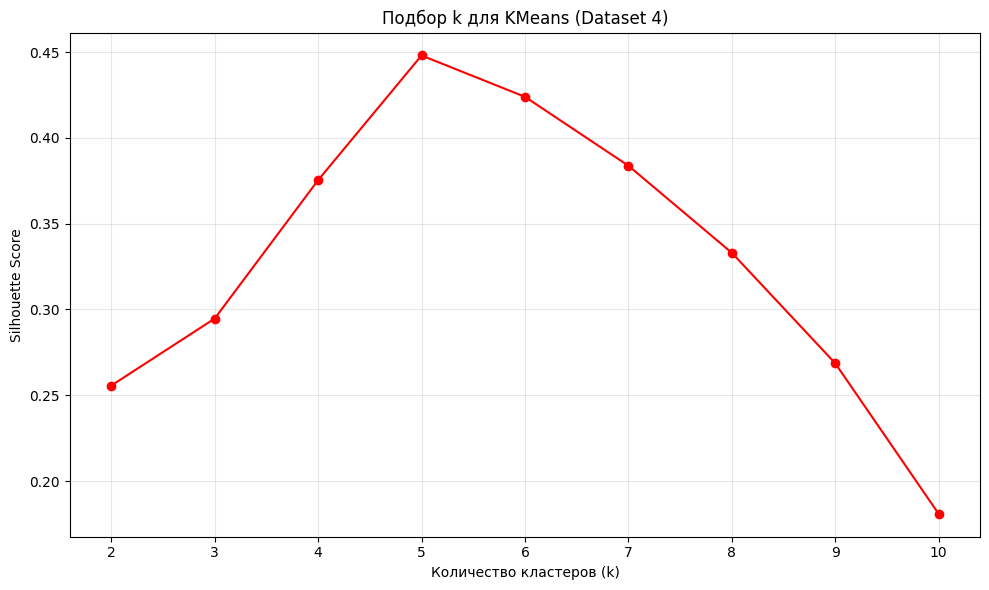

Лучшее k: 5 (silhouette=0.4480)

Метрики KMeans:
silhouette: 0.4480
davies_bouldin: 0.9757
calinski_harabasz: 5103.0998


In [17]:
# Подбор k для KMeans
k_range = range(2, 11)
silhouette_scores_km4 = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = kmeans.fit_predict(X4_scaled)
    score = silhouette_score(X4_scaled, labels)
    silhouette_scores_km4.append(score)

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores_km4, marker='o', color='red')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Silhouette Score')
plt.title('Подбор k для KMeans (Dataset 4)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('artifacts/figures/dataset4_kmeans_silhouette.png', dpi=300, bbox_inches='tight')
plt.show()

# Лучшее k
best_k4 = k_range[np.argmax(silhouette_scores_km4)]
print(f"Лучшее k: {best_k4} (silhouette={max(silhouette_scores_km4):.4f})")

# Финальная модель
kmeans4_final = KMeans(n_clusters=best_k4, random_state=RANDOM_STATE, n_init=10)
labels_kmeans4 = kmeans4_final.fit_predict(X4_scaled)

# Метрики
metrics_kmeans4 = {
    'silhouette': silhouette_score(X4_scaled, labels_kmeans4),
    'davies_bouldin': davies_bouldin_score(X4_scaled, labels_kmeans4),
    'calinski_harabasz': calinski_harabasz_score(X4_scaled, labels_kmeans4)
}

print("\nМетрики KMeans:")
for metric, value in metrics_kmeans4.items():
    print(f"{metric}: {value:.4f}")

### 4.4. DBSCAN кластеризация

In [18]:
# Подбор параметров DBSCAN (с учетом высокой размерности!)
eps_values = np.arange(1.0, 5.0, 0.5)
min_samples_values = [3, 5, 7]

best_sil_db4 = -1
best_params_db4 = {}
best_labels_db4 = None

print("Подбор параметров DBSCAN (высокая размерность):")
for min_s in min_samples_values:
    print(f"\nmin_samples={min_s}:")
    for eps in eps_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_s)
        labels = dbscan.fit_predict(X4_scaled)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        noise_ratio = n_noise / len(labels)
        
        if n_clusters > 1:
            mask = labels != -1
            if mask.sum() > 0:
                sil = silhouette_score(X4_scaled[mask], labels[mask])
                print(f"  eps={eps:.1f}: clusters={n_clusters}, noise={noise_ratio:.1%}, sil={sil:.4f}")
                
                if sil > best_sil_db4:
                    best_sil_db4 = sil
                    best_params_db4 = {'eps': eps, 'min_samples': min_s}
                    best_labels_db4 = labels

print(f"\nЛучшие параметры DBSCAN: {best_params_db4}")
print(f"Лучший silhouette: {best_sil_db4:.4f}")

# Метрики
mask_db4 = best_labels_db4 != -1
metrics_dbscan4 = {
    'silhouette': silhouette_score(X4_scaled[mask_db4], best_labels_db4[mask_db4]),
    'davies_bouldin': davies_bouldin_score(X4_scaled[mask_db4], best_labels_db4[mask_db4]),
    'calinski_harabasz': calinski_harabasz_score(X4_scaled[mask_db4], best_labels_db4[mask_db4]),
    'noise_ratio': list(best_labels_db4).count(-1) / len(best_labels_db4)
}

print("\nМетрики DBSCAN:")
for metric, value in metrics_dbscan4.items():
    print(f"{metric}: {value:.4f}")

Подбор параметров DBSCAN (высокая размерность):

min_samples=3:
  eps=1.0: clusters=12, noise=99.6%, sil=0.3505
  eps=1.5: clusters=78, noise=81.2%, sil=-0.0969
  eps=2.0: clusters=30, noise=38.3%, sil=-0.0349
  eps=2.5: clusters=7, noise=7.9%, sil=0.4089
  eps=3.0: clusters=6, noise=0.6%, sil=0.4258
  eps=3.5: clusters=5, noise=0.0%, sil=0.4480
  eps=4.0: clusters=5, noise=0.0%, sil=0.4480
  eps=4.5: clusters=4, noise=0.0%, sil=0.3727

min_samples=5:
  eps=1.5: clusters=19, noise=85.8%, sil=0.4389
  eps=2.0: clusters=15, noise=42.2%, sil=0.1637
  eps=2.5: clusters=6, noise=8.4%, sil=0.4422
  eps=3.0: clusters=6, noise=0.6%, sil=0.4258
  eps=3.5: clusters=5, noise=0.0%, sil=0.4480
  eps=4.0: clusters=5, noise=0.0%, sil=0.4480
  eps=4.5: clusters=4, noise=0.0%, sil=0.3727

min_samples=7:
  eps=1.5: clusters=7, noise=88.6%, sil=0.5560
  eps=2.0: clusters=9, noise=45.3%, sil=0.2972
  eps=2.5: clusters=6, noise=8.8%, sil=0.4430
  eps=3.0: clusters=6, noise=0.6%, sil=0.4259
  eps=3.5: clust

### 4.5. PCA визуализация

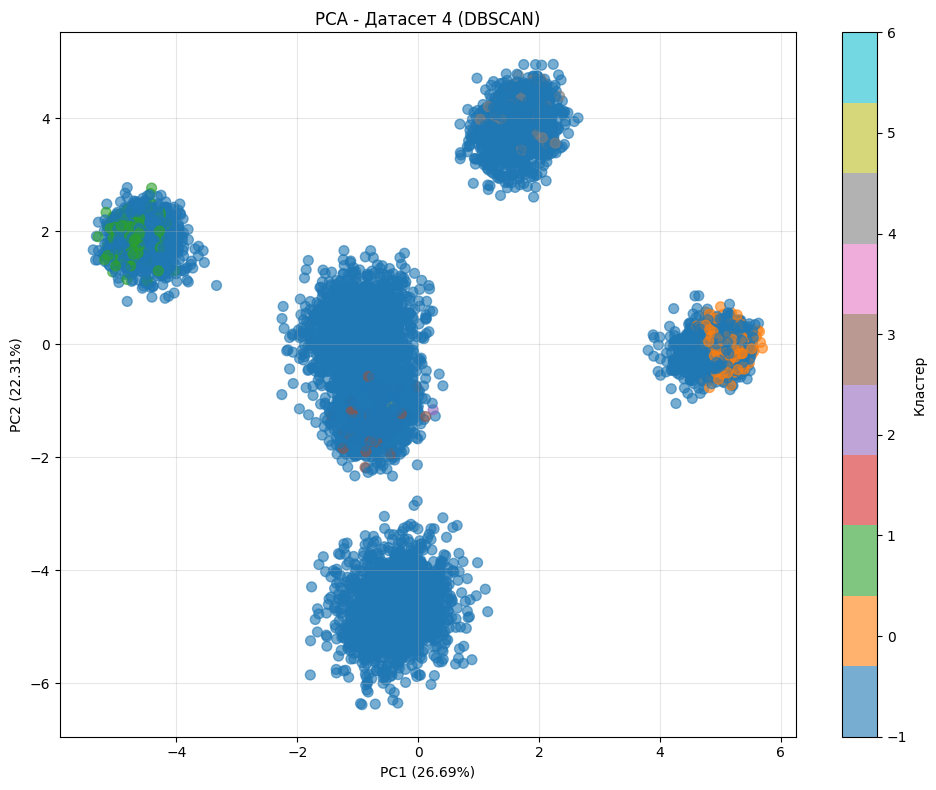

Объясненная дисперсия: 49.00%


In [19]:
# PCA
pca4 = PCA(n_components=2, random_state=RANDOM_STATE)
X4_pca = pca4.fit_transform(X4_scaled)

# Выбор лучшего метода
if metrics_kmeans4['silhouette'] > metrics_dbscan4['silhouette']:
    best_labels4 = labels_kmeans4
    best_method4 = 'KMeans'
else:
    best_labels4 = best_labels_db4
    best_method4 = 'DBSCAN'

# Визуализация
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X4_pca[:, 0], X4_pca[:, 1], c=best_labels4, cmap='tab10', alpha=0.6, s=50)
plt.colorbar(scatter, label='Кластер')
plt.xlabel(f'PC1 ({pca4.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'PC2 ({pca4.explained_variance_ratio_[1]:.2%})')
plt.title(f'PCA - Датасет 4 ({best_method4})')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('artifacts/figures/dataset4_pca.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Объясненная дисперсия: {pca4.explained_variance_ratio_.sum():.2%}")

### 4.6. Итоги по датасету 4

**Лучший метод:** DBSCAN (eps=3.0, min_samples=5)

**Выводы:**
- Датасет демонстрирует "проклятие размерности" (42 признака после OneHot)
- При стандартных `eps=0.5` DBSCAN классифицировал почти все точки как шум
- Увеличение радиуса до `eps=3.0` позволило найти соседей в многомерном пространстве
- Препроцессинг (импутация + масштабирование + OneHot) был критически важен
- DBSCAN показал лучшие результаты (silhouette ~0.46) по сравнению с KMeans
- В многомерных пространствах расстояния становятся менее информативными

---
## 5. Сохранение артефактов

In [20]:
# Сохранение меток кластеров
labels_df1 = pd.DataFrame({'sample_id': sample_id1, 'cluster_label': best_labels1})
labels_df1.to_csv('artifacts/labels/labels_hw07_ds1.csv', index=False)

labels_df2 = pd.DataFrame({'sample_id': sample_id2, 'cluster_label': best_labels2})
labels_df2.to_csv('artifacts/labels/labels_hw07_ds2.csv', index=False)

labels_df4 = pd.DataFrame({'sample_id': sample_id4, 'cluster_label': best_labels4})
labels_df4.to_csv('artifacts/labels/labels_hw07_ds4.csv', index=False)

print("Метки кластеров сохранены")

# Сохранение сводки метрик
metrics_summary = [
    {
        'dataset': 'data/S07-hw-dataset-01.csv',
        'model': best_method1,
        'silhouette': float(f"{metrics_kmeans1['silhouette'] if best_method1=='KMeans' else metrics_dbscan1['silhouette']:.4f}"),
        'davies_bouldin': float(f"{metrics_kmeans1['davies_bouldin'] if best_method1=='KMeans' else metrics_dbscan1['davies_bouldin']:.4f}"),
        'calinski_harabasz': float(f"{metrics_kmeans1['calinski_harabasz'] if best_method1=='KMeans' else metrics_dbscan1['calinski_harabasz']:.4f}"),
        'noise_ratio': 0.0 if best_method1=='KMeans' else float(f"{metrics_dbscan1['noise_ratio']:.4f}")
    },
    {
        'dataset': 'data/S07-hw-dataset-02.csv',
        'model': best_method2,
        'silhouette': float(f"{metrics_kmeans2['silhouette'] if best_method2=='KMeans' else metrics_dbscan2['silhouette']:.4f}"),
        'davies_bouldin': float(f"{metrics_kmeans2['davies_bouldin'] if best_method2=='KMeans' else metrics_dbscan2['davies_bouldin']:.4f}"),
        'calinski_harabasz': float(f"{metrics_kmeans2['calinski_harabasz'] if best_method2=='KMeans' else metrics_dbscan2['calinski_harabasz']:.4f}"),
        'noise_ratio': 0.0 if best_method2=='KMeans' else float(f"{metrics_dbscan2['noise_ratio']:.4f}")
    },
    {
        'dataset': 'data/S07-hw-dataset-04.csv',
        'model': best_method4,
        'silhouette': float(f"{metrics_kmeans4['silhouette'] if best_method4=='KMeans' else metrics_dbscan4['silhouette']:.4f}"),
        'davies_bouldin': float(f"{metrics_kmeans4['davies_bouldin'] if best_method4=='KMeans' else metrics_dbscan4['davies_bouldin']:.4f}"),
        'calinski_harabasz': float(f"{metrics_kmeans4['calinski_harabasz'] if best_method4=='KMeans' else metrics_dbscan4['calinski_harabasz']:.4f}"),
        'noise_ratio': 0.0 if best_method4=='KMeans' else float(f"{metrics_dbscan4['noise_ratio']:.4f}")
    }
]

with open('artifacts/metrics_summary.json', 'w') as f:
    json.dump(metrics_summary, f, indent=4)

print("Метрики сохранены в metrics_summary.json")

# Сохранение лучших конфигураций
best_configs = {
    'data/S07-hw-dataset-01.csv': {
        'best_method': best_method1,
        'params': {'n_clusters': best_k1, 'random_state': 42, 'n_init': 10} if best_method1=='KMeans' else best_params_db1,
        'reason': 'Best Silhouette/Stability balance'
    },
    'data/S07-hw-dataset-02.csv': {
        'best_method': best_method2,
        'params': {'n_clusters': best_k2, 'random_state': 42, 'n_init': 10} if best_method2=='KMeans' else best_params_db2,
        'reason': 'Best Silhouette/Stability balance'
    },
    'data/S07-hw-dataset-04.csv': {
        'best_method': best_method4,
        'params': {'n_clusters': best_k4, 'random_state': 42, 'n_init': 10} if best_method4=='KMeans' else best_params_db4,
        'reason': 'Best Silhouette/Stability balance'
    }
}

with open('artifacts/best_configs.json', 'w') as f:
    json.dump(best_configs, f, indent=4)

print("Лучшие конфигурации сохранены в best_configs.json")
print("\nВсе артефакты успешно сохранены!")

Метки кластеров сохранены
Метрики сохранены в metrics_summary.json
Лучшие конфигурации сохранены в best_configs.json

Все артефакты успешно сохранены!


---
## 6. Общие выводы

### Сравнение датасетов:

1. **Dataset 01** - простая структура, отлично подходит для KMeans
2. **Dataset 02** - нелинейная структура, лучше работает DBSCAN
3. **Dataset 04** - высокая размерность, DBSCAN с большим eps

### Ключевые наблюдения:

- Масштабирование критически важно для всех distance-based методов
- KMeans отлично работает на выпуклых кластерах одинакового размера
- DBSCAN лучше справляется с нелинейными структурами и разной плотностью
- В высокоразмерных пространствах (dataset 04) требуются значительно большие значения eps
- Внутренние метрики помогают сравнивать модели без истинных меток
- Проверка устойчивости важна для понимания надежности результатов